# Statistics of ideal mixing
Testing the sampling of the `SaltSwap` code by analysing a transformation where change in total energy should be exactly zero. Here, the non-bonded parameters of the two TIP3P water molecules are "exchanged" with the non-bonded parameters of two TIP3P water molecules, which are labelled as 'cations' and 'anions'. 

This notebook tests:
 1. Whether the `SaltSwap` code correctly samples from the target distribution. This is achieved by comparing simulation with an analytical formula for the null transformation described above.
 2. To quantify the shadow work accumulated during NCMC with a velocity Verlet propagation kernel and its affect on the acceptance rates.

In [ ]:
# Loading modules and pretty colours

from simtk import openmm, unit
from simtk.openmm import app
from openmmtools.testsystems import WaterBox
import sys
sys.path.append("../saltswap/")
sys.path.append("../SAMS/")
from calibrate import MCMCSampler
from saltswap import SaltSwap
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
# Nice colours, taken on 26th Nov 2015 from:
#http://tableaufriction.blogspot.co.uk/2012/11/finally-you-can-use-tableau-data-colors.html

# These are the "Tableau" colors as RGB. I've chosen my faves. 
# In order: blue, green, purple, orange. Hopefully a good compromise for colour-blind people.
tableau4 = [(31, 119, 180),(44, 160, 44),(148,103,189),(255, 127, 14)]
tableau4_light = [(174,199,232),(152,223,138),(197,176,213),(255,187,120)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts. 
for i in range(len(tableau4)):    
    r, g, b = tableau4[i]    
    tableau4[i] = (r / 255., g / 255., b / 255.)
    r, g, b = tableau4_light[i]    
    tableau4_light[i] = (r / 255., g / 255., b / 255.)

As with other notebooks, the test system will be small box of water.

In [2]:
size = 20.0*unit.angstrom     
temperature = 300*unit.kelvin
pressure = 1*unit.atmospheres
delta_chem = 0*unit.kilojoule_per_mole
wbox = WaterBox(box_edge=size,nonbondedMethod=app.PME)
Nmols = wbox.system.getNumParticles()/3.0

# Chemical potential and average numbers

For the reaction when two water molecules are exchanged for an anion and cation pair that have equal interaction energies, the ratio of water molecules to salt molecules is given by

$$ \exp\left(-\frac{\beta\Delta \mu }{2}\right) = \frac{n_w}{n_s} $$

where $\beta\Delta \mu$ is the applied (dimentionless) difference in chemical potential between water and salt, and $n_w$ and $n_s$ are the number of water molecules and salt molecules respectively. The factor of 1/2 in the exponent comes from the fact that two water molecules are exchanged for two ions.

Below, a range of chemical potentials are applied to equilibrium sampling of instantaneous switching of 2 water molecules 2 two water molecules that are labelled as salt. The average number of molecules and ratios between water and 'salt' molecules are recorded.

In [4]:
mus = [-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2] # The chemical potentials

r = np.zeros(len(mus))      # mean ratio of water to salt
rstd = np.zeros(len(mus))   # standard deviation of water to salt
w = np.zeros(len(mus))      # mean number of waters
s = np.zeros(len(mus))      # mean number of salt pairs

Nsamps=500         # The mean number of samples per chemical potential

for i in range(len(mus)):
    dummystate = MCMCSampler(wbox.system,wbox.topology,wbox.positions,delta_chem=mus[i])
    dummystate.saltswap.cation_parameters = dummystate.saltswap.water_parameters
    dummystate.saltswap.anion_parameters = dummystate.saltswap.water_parameters
    Nwats = []
    Nsalts = []
    ratio = []
    for block in range(Nsamps):
        dummystate.gen_label(saltsteps=20)
        (nwats,nsalt,junk) = dummystate.saltswap.getIdentityCounts()
        ratio.append(1.0*nwats/nsalt)
        Nwats.append(nwats)
        Nsalts.append(nsalt)
    w[i] = (np.array(Nwats)/Nmols).mean()  
    s[i] = (np.array(Nsalts)/Nmols).mean()
    ratio = np.array(ratio)
    r[i] = ratio[100:].mean()
    rstd[i] = ratio[100:].std()

KeyboardInterrupt: 

Comparing the sampled ratios of water to salt molecules to the analytical formula:

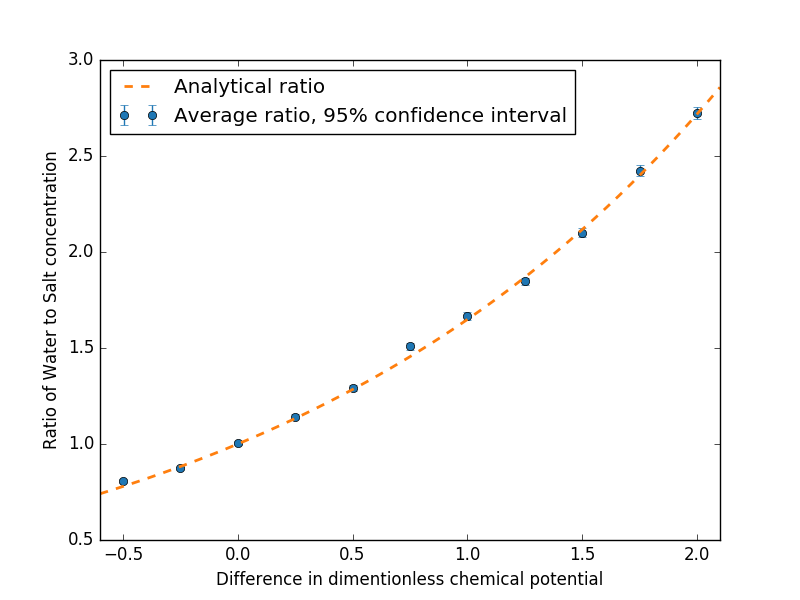

In [214]:
mus = np.array(mus)
delta = 0.1
xlims = (mus[0]-delta,mus[-1]+delta)
x = np.linspace(xlims[0],xlims[1])

plt.clf()
plt.errorbar(mus,r,yerr=2*rstd/np.sqrt(Nsamps),fmt='o',color=tableau4[0])
plt.plot(x,np.exp(np.array(x)/2), 'r--',linewidth=2,color=tableau4[3])
#plt.plot(mus,w/s,color=tableau4[1])
plt.xlim(xlims)
#plt.ylim((0.75,3))
plt.xlabel('Difference in dimentionless chemical potential')
plt.ylabel('Ratio of Water to Salt concentration')
plt.legend(['Analytical ratio','Average ratio, 95% confidence interval'],loc=2)
plt.show()
plt.savefig('RatioComparison.png',format='png')
Image('RatioComparison.png')

There appears to be reasonable agreement between theory and simulation, except at $\Delta \mu =0$, where the 95% confidense region does not overlap with the analytical formula. This may be due to numerical errors accumulated during the instant switching, investigated below. 

# The effect of shadow work on the acceptance rate

In this section, the work and acceptance probability for instant swiching will be compared to work and acceptance probability an NCMC protocol.

Initialising the `MCMCSampler` object and changing the ion parameters to the same as water, so that there is no change in energy when salt is 'added':

In [89]:
state = MCMCSampler(wbox.system,wbox.topology,wbox.positions)
state.saltswap.cation_parameters = state.saltswap.water_parameters
state.saltswap.anion_parameters = state.saltswap.water_parameters

**INSTANT SWITCHES**

The work for switching parameters _should_ be exactly 0 for null transformations, which are generated below.

In [90]:
Nwats = []
Nsalts = []
for block in range(500):
    state.gen_label(saltsteps=20)
    (nwats,nsalt,junk) = state.saltswap.getIdentityCounts()
    Nwats.append(nwats)
    Nsalts.append(nsalt)

In [230]:
inst_work = np.hstack((state.saltswap.work_add,state.saltswap.work_rm))
print 'Fraction of null transformations that are'
print '    1. Exactly 0:', np.sum(inst_work==0)/(1.0*inst_work.shape[0])
print '    2. greater than 0:',np.sum(inst_work>0)/(1.0*inst_work.shape[0])
print '    3. less than 0:',np.sum(inst_work<0)/(1.0*inst_work.shape[0])

print 'The (dimentionless) non-zero work values have an average value of {0} (no units)'.format(np.mean(np.abs(inst_work[inst_work!=0])))

Fraction of null transformations that are
    1. Exactly 0: 0.524311196442
    2. greater than 0: 0.236662892401
    3. less than 0: 0.239025911157
The (dimentionless) non-zero work values have an average value of 1.4217145547e-05 (no units)


Viewing the average number of salt pairs as time progresses. Note that the variance of the number of water molecules is twice that for the cations, as expected.

Mean fraction of water molecules = 0.331 +/- 0.0559
Mean fraction of cations = 0.334 +/- 0.028
Acceptance probability = 0.905
Ratio of variance: std(water)/std(cation) = 2.000


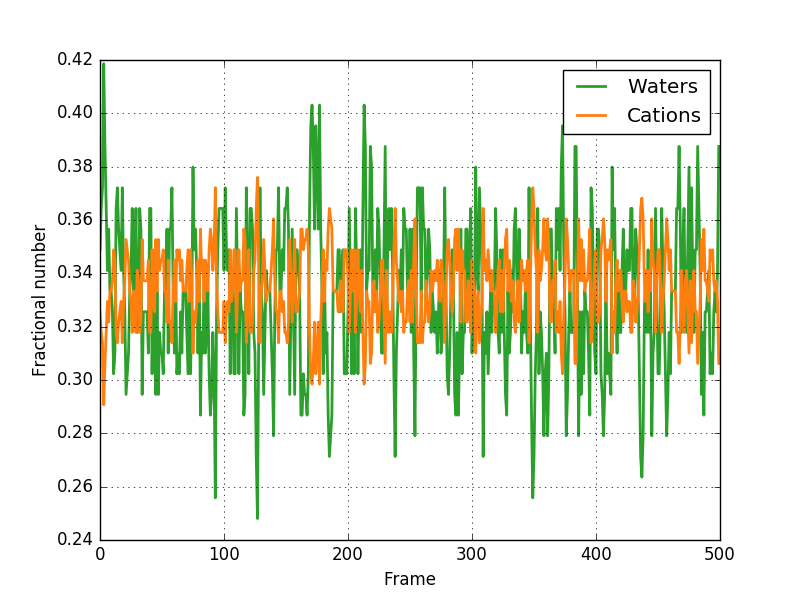

In [91]:
time = np.arange(len(Nwats))
Nwats = np.array(Nwats)
Nsalts = np.array(Nsalts)

plt.clf()
plt.grid(True)
plt.plot(Nwats/Nmols,color=tableau4[1],linewidth=2)
#plt.plot(Nwats/Nmols,color=tableau4_light[1],linewidth=1)
plt.plot(Nsalts/Nmols,color=tableau4[3],linewidth=2)
#plt.plot(Nsalts/Nmols,color=tableau4_light[3],linewidth=1)
plt.xlabel('Frame')
plt.ylabel('Fractional number')
plt.legend(['Waters','Cations'])
plt.savefig('InstSwictch.png',format='png')
print 'Mean fraction of water molecules = {:.3f} +/- {:.3}'.format((Nwats/Nmols).mean(),2*(Nwats/Nmols).std())
print 'Mean fraction of cations = {:.3f} +/- {:.3}'.format((Nsalts/Nmols).mean(),2*(Nsalts/Nmols).std())
print 'Acceptance probability = {:.3f}'.format(state.saltswap.getAcceptanceProbability())
print 'Ratio of variance: std(water)/std(cation) = {:.3f}'.format(Nwats.std()/Nsalts.std())
Image('InstSwictch.png')

**SWITCHES WITH NCMC**

As above, performing null transformations (transforming 2 water molecules into 2 water molecules). This time, NCMC will be performed with velocity Verlet propagation  kernels with the parameters:

* Number of perturbation kernels = 512
* Number of propagation kernels = 1

In [7]:
ncstate = MCMCSampler(wbox.system,wbox.topology,wbox.positions,nkernels = 500,nverlet=1)
ncstate.saltswap.cation_parameters = ncstate.saltswap.water_parameters
ncstate.saltswap.anion_parameters = ncstate.saltswap.water_parameters

In [8]:
ncNwats = []
ncNsalts = []
for block in range(500):
    ncstate.gen_label(saltsteps=20)
    (nwats,nsalt,junk) = ncstate.saltswap.getIdentityCounts()
    ncNwats.append(nwats)
    ncNsalts.append(nsalt)

In [233]:
nc_work = np.hstack((ncstate.saltswap.work_add,ncstate.saltswap.work_rm))
print 'Fraction of null transformations that are'
print '    1. Exactly 0:', np.sum(nc_work==0)/(1.0*nc_work.shape[0])
print '    2. greater than 0:',np.sum(nc_work>0)/(1.0*nc_work.shape[0])
print '    3. less than 0:',np.sum(nc_work<0)/(1.0*nc_work.shape[0])

print 'The (dimentionless) non-zero work values have an average value of {0} (no units)'.format(np.mean(np.abs(nc_work[nc_work!=0])))

Fraction of null transformations that are
    1. Exactly 0: 0.0
    2. greater than 0: 0.454
    3. less than 0: 0.546
The (dimentionless) non-zero work values have an average value of 16.6581380648 (no units)


Unlike the instant swiches protocol, **none** of the transformations are exactly zero. 

Mean fraction of water molecules = 0.331 +/- 0.212
Mean fraction of cations = 0.335 +/- 0.106
Acceptance probability = 0.568
Ratio of variance: std(water)/std(cation) = 2.000


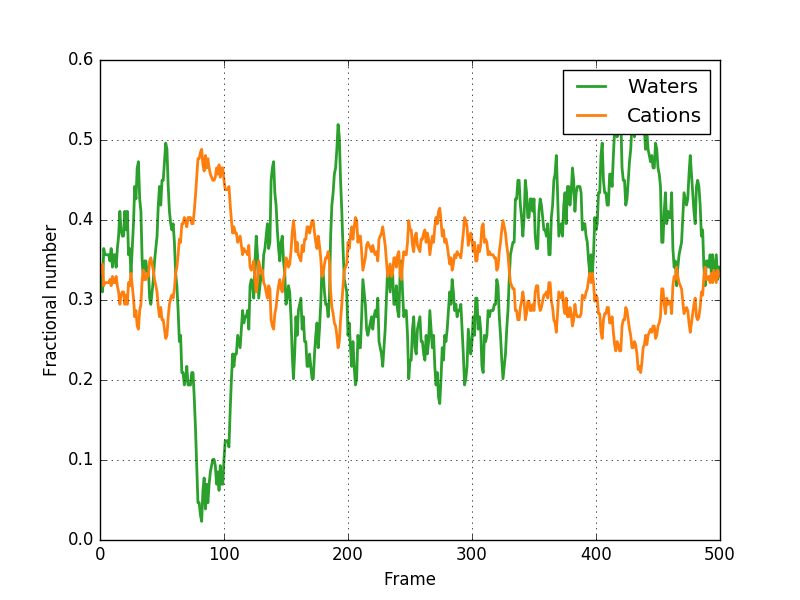

In [88]:
time = np.arange(len(ncNwats))
ncNwats = np.array(ncNwats)
ncNsalts = np.array(ncNsalts)

plt.clf()
plt.grid(True)
plt.plot(ncNwats/Nmols,color=tableau4[1],linewidth=2)
#plt.plot(Nwats/Nmols,color=tableau4_light[1],linewidth=1)
plt.plot(ncNsalts/Nmols,color=tableau4[3],linewidth=2)
#plt.plot(Nsalts/Nmols,color=tableau4_light[3],linewidth=1)
plt.xlabel('Frame')
plt.ylabel('Fractional number')
plt.legend(['Waters','Cations'])
plt.savefig('NCMC_nk500_nV1.png',format='png')
print 'Mean fraction of water molecules = {:.3f} +/- {:.3}'.format((ncNwats/Nmols).mean(),2*(ncNwats/Nmols).std())
print 'Mean fraction of cations = {:.3f} +/- {:.3}'.format((ncNsalts/Nmols).mean(),2*(ncNsalts/Nmols).std())
print 'Acceptance probability = {:.3f}'.format(ncstate.saltswap.getAcceptanceProbability())
print 'Ratio of variance: std(water)/std(cation) = {:.3f}'.format(ncNwats.std()/ncNsalts.std())
Image('NCMC_nk500_nV1.png')

**The acceptance probability has gone from around 90% with instant switches to around 56% with the NCMC protocol!**

## Work distributions due to shadow work
Looking at the distribution of the shadow work

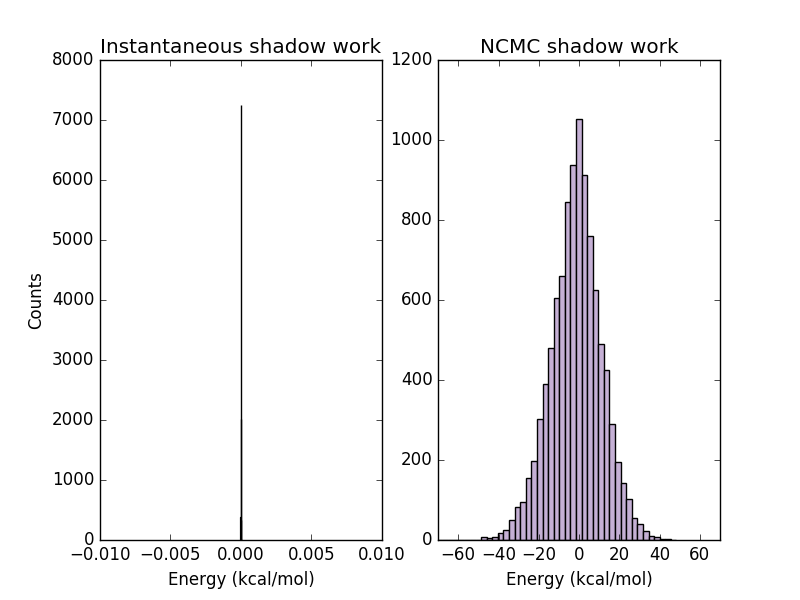

In [92]:
plt.clf()
#n, bins, patches = plt.hist(nc_work_rm, 50, normed=1, facecolor=tableau4_light[2])

plt.savefig('temp.png',format='png')
Image('temp.png')

f, axarr = plt.subplots(1, 2)
coords = [(0,0),(0,1)]
xlims =(-70,70)       # x limits
ylims = (0,0.025)       # y limits


axarr[0].hist(np.hstack((inst_work_add,inst_work_rm))*0.592, 5, normed=False, facecolor=tableau4_light[2])
axarr[0].set_xlim({-0.01,0.01})
#axarr[0].set_xlim(xlims)
#axarr[0].set_ylim(ylims)
axarr[0].set_xlabel('Energy (kcal/mol)')
axarr[0].set_ylabel('Counts')
axarr[0].set_title('Instantaneous shadow work')
axarr[1].hist(np.hstack((nc_work_add,nc_work_rm))*0.592, 50, normed=False, facecolor=tableau4_light[2])
axarr[1].set_xlim(xlims)
#axarr[1].set_ylim(ylims)
axarr[1].set_xlabel('Energy (kcal/mol)')
axarr[1].set_title('NCMC shadow work')
#plt.setp(axarr[1].get_yticklabels(),visible=False)  

plt.savefig("ShadowWork.png", format='png')
Image("ShadowWork.png")